In [1]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from squidpy.pl._utils import save_fig
from time import process_time

sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3
sc.settings.dpi = 300
sq.__version__
sc.settings.figdir = "./figures"

%load_ext autoreload
%autoreload 2
%load_ext lab_black

scanpy==1.7.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
adata_visium = sq.datasets.visium_fluo_adata()
adata_seqfish = sq.datasets.seqfish()
adata_fouri = sq.datasets.four_i()
adata_imc = sq.datasets.imc()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
dic_list = []
for i in np.arange(10):
    for adata, data_id, cluster_id in zip(
        [adata_visium, adata_seqfish, adata_fouri, adata_imc],
        ["visium", "seqfish", "4i", "imc"],
        ["cluster", "celltype_mapped_refined", "cluster", "cell type"],
    ):
        start_t = process_time()
        sq.gr.spatial_neighbors(adata, coord_type="generic")
        duration_graph = process_time() - start_t

        start_t = process_time()
        sq.gr.nhood_enrichment(adata, cluster_key=cluster_id)
        duration_nhood = process_time() - start_t

        dic_list.append(
            {
                "dataset": data_id,
                "time_nhood": duration_nhood,
                "time_graph": duration_graph,
                "n_obs": adata.shape[0],
                "n_cluster": adata.obs[cluster_id].cat.categories.shape[0],
                "idx": i,
            }
        )

Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Adding `adata.uns['cluster_nhood_enrichment']`
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Adding `adata.uns['celltype_mapped_refined_nhood_enrichment']`
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:01)
Adding `adata.uns['cluster_nhood_enrichment']`
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Adding `ada

In [58]:
df = pd.DataFrame(dic_list)
df = df.groupby(["dataset", "n_obs"]).mean()
df.reset_index(drop=False, inplace=True)
df = df[["dataset", "time_nhood", "time_graph", "n_obs"]].copy()
df.rename(
    columns={"time_nhood": "nhood_enrichment", "time_graph": "graph"}, inplace=True
)
df = df.melt(
    id_vars="dataset",
    value_vars=["nhood_enrichment", "graph"],
    value_name="mean",
    var_name="method",
)
df["tool"] = "squidpy"
df

obs_df = pd.DataFrame(dic_list)
obs_df = obs_df[["n_obs", "n_cluster", "dataset"]].copy()
obs_df.drop_duplicates(inplace=True)
obs_df.reset_index(inplace=True, drop=True)

In [59]:
giotto = pd.read_csv("./benchmark_giotto_results.csv", index_col=0)
giotto.rename(columns={"expr": "method"}, inplace=True)
giotto = giotto[["method", "mean", "dataset"]].copy()
giotto = giotto[giotto.method != "net_delaunay"].copy()
giotto.replace({"net_knn": "graph", "cellproxy": "nhood_enrichment"}, inplace=True)
giotto["tool"] = "giotto"
giotto

,method,mean,dataset,tool
2,graph,1.191415,seqfish,giotto
3,nhood_enrichment,53.047965,seqfish,giotto
5,graph,0.252520,imc,giotto
6,nhood_enrichment,11.025791,imc,giotto
8,graph,0.152960,visium,giotto
9,nhood_enrichment,7.544237,visium,giotto
11,graph,18.656506,4i,giotto
12,nhood_enrichment,3494.298143,4i,giotto


In [111]:
final_df = pd.concat([df, giotto], axis=0)
final_df = final_df.merge(obs_df, on="dataset")
final_df["log_mean"] = np.log10(1 + final_df["mean"].values)
final_df["log_n_obs"] = np.log10(1 + final_df["n_obs"].values)
final_df

,dataset,method,mean,tool,n_obs,n_cluster,log_mean,log_n_obs
0,4i,nhood_enrichment,20.915312,squidpy,270876,10,1.340748,5.432772
1,4i,graph,1.299086,squidpy,270876,10,0.361555,5.432772
2,4i,graph,18.656506,giotto,270876,10,1.293506,5.432772
3,4i,nhood_enrichment,3494.298143,giotto,270876,10,3.543484,5.432772
4,imc,nhood_enrichment,0.386760,squidpy,4668,11,0.142001,3.669224
5,imc,graph,0.020546,squidpy,4668,11,0.008832,3.669224
6,imc,graph,0.252520,giotto,4668,11,0.097785,3.669224
7,imc,nhood_enrichment,11.025791,giotto,4668,11,1.080114,3.669224
8,seqfish,nhood_enrichment,1.817367,squidpy,19416,22,0.449843,4.288182
9,seqfish,graph,0.048500,squidpy,19416,22,0.020568,4.288182


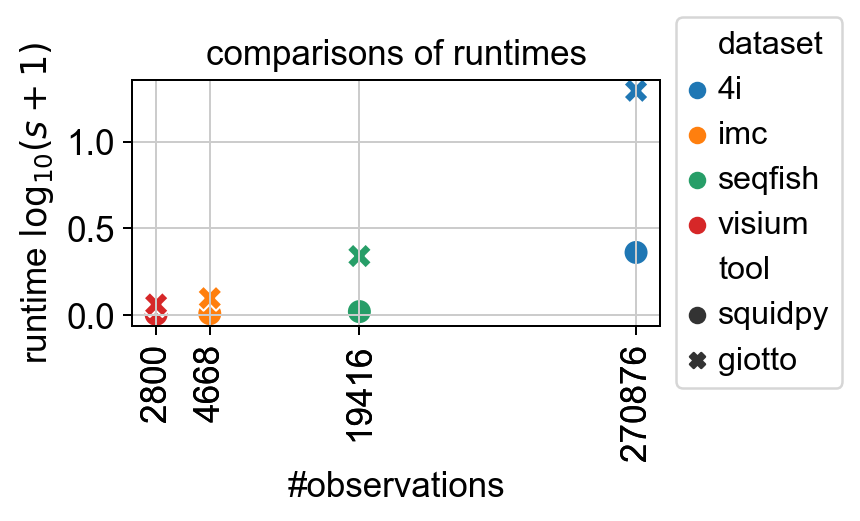

In [121]:
fig, ax = plt.subplots(tight_layout=True, dpi=180, figsize=(5, 3))
data = final_df[final_df.method == "graph"]
sns.scatterplot(
    data=data, x="log_n_obs", y="log_mean", hue="dataset", style="tool", s=100, ax=ax
)
plt.xticks(data.log_n_obs.values, data.n_obs.values, rotation=90)
ax.set_ylabel(r"runtime $\log_{10}(s+1)$")
ax.set_xlabel("#observations")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = ax.set_title("comparisons of runtimes")

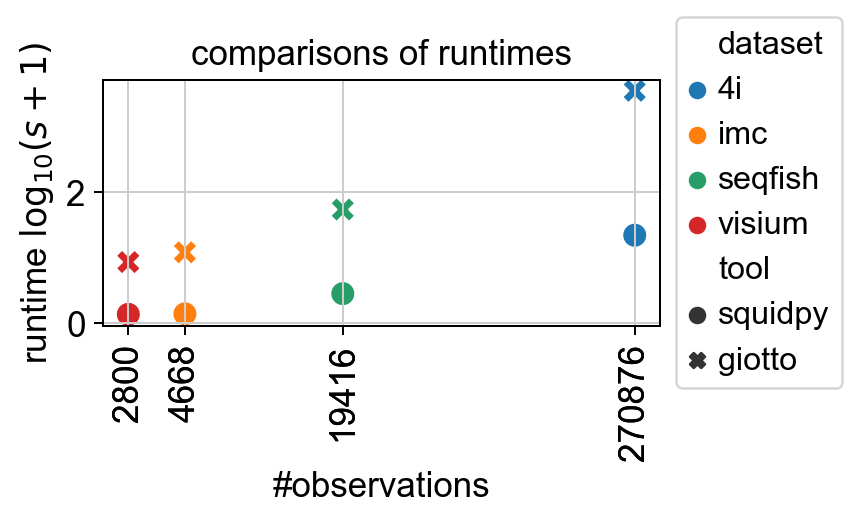

In [122]:
fig, ax = plt.subplots(tight_layout=True, dpi=180, figsize=(5, 3))
data = final_df[final_df.method == "nhood_enrichment"]
sns.scatterplot(
    data=data, x="log_n_obs", y="log_mean", hue="dataset", s=100, style="tool", ax=ax
)
plt.xticks(data.log_n_obs.values, data.n_obs.values, rotation=90)
ax.set_ylabel(r"runtime $\log_{10}(s+1)$")
ax.set_xlabel("#observations")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = ax.set_title("comparisons of runtimes")